# Question 1. (50 points)
**This first question will serve as an introduction to working with modAL in order to implement some of the basic active learning concepts we have covered thus far in lecture. This includes pool-based sampling, as well as query by committee. Conveniently, modAL includes the ActiveLearner and Committee classes, which helps make both of these steps simpler. You will be required to instantiate the appropriate objects using these classes, utilize modAL supported query strategies, as well as implement one of your own. In doing so, you will perform some of your first active learning experiments, and report the results as asked below.**

- **You are provided with an imaging data set `Data.csv`. This data comprises 500 samples each with 26 features. Each sample is labeled with one of ten possible subcellular locations.** 
- **You are also given the Jupyter Notebook template for completing this assignment. Notice the cell below will load and partition the data for you.**

## Imports

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import copy

### modAL 
from modAL.models import ActiveLearner, Committee 
from modAL.density import information_density
from modAL.disagreement import max_disagreement_sampling, vote_entropy_sampling
from modAL.uncertainty import uncertainty_sampling, entropy_sampling, margin_sampling, classifier_entropy, classifier_margin, classifier_uncertainty

### sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


### Suppresses Warning
import warnings
warnings.filterwarnings('ignore')


### Set random seed
seed = 10 
np.random.seed(seed)

### Set number of queries for active learning
queries = 100

##  Reading and Processing the Data
Separate the data into three subsets: 
- training set to provide to active learner as the starting set of labeled data
- pool set to sample from during active learning
- test set to score active learner

In [2]:
# read in data
data = pd.read_csv('data/q1/Data.csv')

In [3]:
# take a look
data.head()

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,...,Feature18,Feature19,Feature20,Feature21,Feature22,Feature23,Feature24,Feature25,Feature26,Label
0,-1.248343,-1.615585,-1.610578,-1.672871,-1.713508,-1.872432,-2.409608,-2.305494,2.114938,-0.413445,...,0.491083,-0.317178,-0.265245,-0.272077,-0.430179,0.084602,0.003779,-0.649326,-0.723756,Plasma_Membrane
1,-1.226355,-1.224572,-1.356628,-1.226604,-1.166955,-1.328468,-1.667473,-1.615286,1.515357,-0.588017,...,0.518482,-0.669137,-0.664697,-0.775208,-0.811765,-0.503596,-0.518217,-0.939116,-1.049305,Mitochondria
2,-1.194688,-1.326673,-1.365453,-0.679505,-0.755368,-0.306467,-1.615293,-1.331803,1.066737,-0.647715,...,0.059239,-0.581023,-0.307099,-0.100065,0.796825,2.428108,2.706549,2.385857,1.842656,Late_Endosomes
3,-1.137572,-0.740138,-1.269620,-0.491891,-0.003291,0.320572,-0.200528,-0.223160,0.249195,-0.279571,...,-0.105456,-0.275270,-0.153862,-0.283888,0.312168,0.645984,0.944613,0.833160,0.681339,Late_Endosomes
4,-1.135937,-1.146888,-1.256864,-1.253807,-1.336455,-1.366332,-1.749063,-1.846707,1.609479,-0.470157,...,0.783125,-0.539422,-0.647164,-0.750957,-0.909421,-1.112221,-1.227274,-1.413799,-1.514076,Mitochondria


### Encode Data

In [4]:
# convert features DataFrame to numpy 2D array
X = data.iloc[:,:26].values

# convert labels to unique numbers then to numpy 1D array
y = LabelEncoder().fit_transform(data.iloc[:,-1])

### Split Data

In [5]:
# training set contains one instance from each of 10 labels
X_training, y_training = [], []
for i in range(10):
    
    # return index of first element in list with label i
    unique_label_idx = list(y).index(i)
    
    # get the feature array corresponding to this element
    xx = X[unique_label_idx]
    
    # add instance to training data
    X_training.append(xx)
    y_training.append(i)
    
    # remove instance from original data
    X, y = np.delete(X, unique_label_idx, axis=0), np.delete(y, unique_label_idx, axis=0)

    
# split remaining data into pool and test subsets
X_pool, X_test, y_pool, y_test = train_test_split(X,y,test_size=0.5,random_state=seed)

# convert lists to numpy arrays
X_training = np.asarray(X_training)
y_training = np.asarray(y_training)

In [6]:
# sanity check
print('X:',X.shape)
print('y:',y.shape)
print('X_training:',X_training.shape)
print('y_training:',y_training.shape)
print('X_pool:',X_pool.shape)
print('y_pool:',y_pool.shape)
print('X_test:',X_test.shape)
print('y_test:',y_test.shape)

X: (490, 26)
y: (490,)
X_training: (10, 26)
y_training: (10,)
X_pool: (245, 26)
y_pool: (245,)
X_test: (245, 26)
y_test: (245,)


# Part 0. Review for logistical regression and random forest (0 pt.)
**In this problem we are going to test different query strategies on two types of machine learning algorims: Logistic Regression and Random Forest. We can see the classification accuracy for both models in supervised learning setting in the cell below. If labels are abundant and classes are well-separated in feature space, the classifiers can classify the different classes with high accuracy.**

**Do not change the random seed.**

In [7]:
'''
As a benchmark, first find the maximum accuracy possible, given the entire pool of data
'''

# train LR model on entire pool of data
lr = LogisticRegression()
lr.fit(X_pool, y_pool)

# train RFC model on entire pool of data
N_estimator_rf = 20
MAX_depth_rf = 6
rf = RandomForestClassifier(n_estimators = N_estimator_rf, 
                            max_depth = MAX_depth_rf, 
                            random_state = seed)
rf.fit(X_pool, y_pool)

# calculate accuracy
print('Accuracy of Logistic Regression: \t{:.3f}'.format(lr.score(X_test,y_test)))
print('Accuracy of Random Forest: \t\t{:.3f}'.format(rf.score(X_test,y_test)))

Accuracy of Logistic Regression: 	0.898
Accuracy of Random Forest: 		0.861


# 1.1. Random Sampling (5 pts. total) 

**Create a `random_query()` function that provide a method for randomly selecting a sample to query from the oracle, and must be consistent with the query methods expected by modAL when called.**

- **Perform random sampling for 100 calls to the oracle with each ActiveLearner.**

- **After each call to the oracle, measure the accuracy of each learner on predictions across the test sets (X_test and y_test).**

- **Report the final accuracy and make a plot with query number as the x-axis and accuracy as the y-axis.** 

**Hint: Check the <a href="https://modal-python.readthedocs.io/en/latest/index.html"> modAL documentation</a> for how to call an ActiveLearner. Within the documentation, check the Extending modAL section for a tutorial on implementing a custom query strategy.**

**Do not change the random seed.**

## 1.1. Function Definitions

In [8]:
def random_query(classifier, X):
    '''
    Defines query strategy for an ActiverLearner in which a single
    random sample is selected with replacement from pool X of data.
    
    Args:
        classifier: Argument provided by the ActiverLearner, unused 
        by this function, but required to correctly position 
        argument X.
                
        X: pool of feature data from which to sample.
        
    Returns:
        (int, numpy array) Tuple containing (index of sample, sample features). 
    '''
    
    n_samples = len(X)
    query_idx = np.random.choice(range(n_samples))
    return query_idx, X[query_idx]

In [9]:
def get_next_sample(learner, X, y):
    '''
    Queries the pool X of data and selects a new sample 
    using the query_strategy of the ActiveLearner.
    
    Args:
        learner: the ActiveLearner within which a 
        query_strategy is defined.
    
        X: the pool of data from which to select a sample.
        This is a numpy array of feature instances.
    
        y: the pool of labels corresponding to X instances.
        This is a numpy array of labels. 
        
    Returns:
        (X,y,idx) tuple of the selected sample, where idx 
        is the index of the selected sample.
    
    
    Notes on reshaping:
    (1) query_sample is a 1D numpy array indexed 0 to 25. The teach() 
        function of the learner expects a collection of elements, where each
        element in the collection has 26 features. In its original format,
        query_sample is interpreted as a collection of 26 elements, each with 
        1 feature. We need to reshape it so that the array is interpreted as 
        a collection of one element with 26 features.
        
    (2) query_label is a integer. The teach() function of the learner expects
        a collection of elements, where each element in the collection has 1 
        value. We need to reshape it so that the variable is interpreted as a
        collection of one element with 1 value.
    '''
    
    # call the query strategy defined in the learner to obtain a new sample
    query_idx, query_sample = learner.query(X)
    
    # modify indexing to interpret as collection of one element with 26 features
    query_sample_reshaped = query_sample.reshape(1,-1)
   
    # obtain the query label
    query_label = y[query_idx]

    # modify indexing to interpret as 1D array of one element
    query_label_reshaped = query_label.reshape(1,)
    
    return query_sample_reshaped, query_label_reshaped, query_idx

In [10]:
def run_active_learner(learner, X_pool, y_pool, X_test, y_test, num_queries):
    '''
    Performs active learning using given ActiveLearner. Runs for 
    the given number of queries. Each iteration draws from the pool of 
    data using the learner's query_strategy, updates the model, 
    then scores the model against given test data. 
    
    Args:   
        learner: the ActiveLearner
    
        X_pool: the pool of feature data from which to sample
    
        y_pool: the labels corresponding to the X_pool
    
        X_test: the collection of data with which to score 
        the model
    
        y_test: the labels corresponding to the X_test
    
        num_queries: the number of queries (iterations) to 
        execute during active learning.
     
     
    Returns:
        List of scores, in query order, starting with a score 
        representing the model before any queries.
    '''
    history = [] # score history
    
    # score model before active learning starts
    history.append(learner.score(X_test,y_test))

    # perform active learning
    for idx in range(num_queries):

        # get sample
        X_sample, y_sample, query_idx = get_next_sample(learner, X_pool, y_pool)

        # use new sample to update the model
        learner.teach(X_sample, y_sample)

        # score against test data
        current_score = learner.score(X_test,y_test)

        # save score
        history.append(current_score)
        
        # remove labeled instance from pool
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx)
        
    return history


## 1.1. Logistic Regression (2.5 pts.)
**Use logistic regression as estimator to your active learner.**

In [11]:
# copy data for use with this section
X_pool_rand_lr = copy.deepcopy(X_pool)
y_pool_rand_lr = copy.deepcopy(y_pool)


# define learner, including training data as starting point
learner = ActiveLearner(
    estimator=LogisticRegression(),
    query_strategy=random_query,
    X_training=X_training, 
    y_training=y_training
)


# run active learner and obtain score history
history_rand_lr = run_active_learner(learner, X_pool_rand_lr, y_pool_rand_lr, X_test, y_test, queries)


In [12]:
# final accuracy
print('Final accuracy of Logistic Regression with random sampling: \t{:.3f}'.format(history_rand_lr[-1]))

Final accuracy of Logistic Regression with random sampling: 	0.869


## 1.1. Plot classification accuracy with respect to number of labels queried

In [13]:
def plot_performance_single_model(score_history):
    '''
    Generates a scatterplot of total queries vs score, 
    from given score_history.
    
    Args:
        score_history: A list of scores representing the 
        score of the ActiveLearner after each query.
    '''
    
    fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

    ax.plot(score_history)
    ax.scatter(range(len(score_history)), score_history, s=13)

    ax.set_ylim(bottom=0, top=1)
    ax.grid(True)

    ax.set_title('Incremental classification accuracy')
    ax.set_xlabel('Query iteration')
    ax.set_ylabel('Classification Accuracy')

    plt.show()

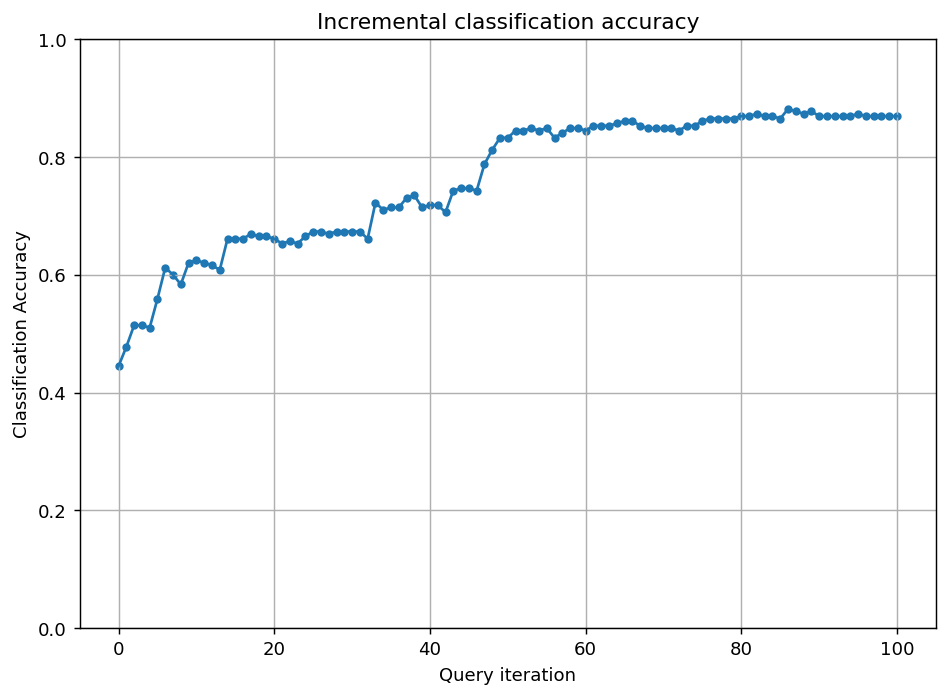

In [14]:
# plot our performance over time
plot_performance_single_model(history_rand_lr)

## 1.1. Random Forest (2.5 pts.)

**Use random forest as estimator to your active learner.** 

- **Use 20 estimators with max depth of 6.**
- **Set the seed for the random forest classifier as the same seed above.**

In [15]:
# copy data for use with this section
X_pool_rand_rf = copy.deepcopy(X_pool)
y_pool_rand_rf = copy.deepcopy(y_pool)


# define learner, including training data as starting point
learner = ActiveLearner(
    estimator=RandomForestClassifier(n_estimators=20,max_depth=6,random_state=seed),
    query_strategy=random_query,
    X_training=X_training, 
    y_training=y_training
)


# run active learner and obtain score history
history_rand_rf = run_active_learner(learner,X_pool_rand_rf, y_pool_rand_rf, X_test, y_test, queries)

In [16]:
# final accuracy
print('Final accuracy of Random Forest Classifier with random sampling: \t{:.3f}'.format(history_rand_rf[-1]))

Final accuracy of Random Forest Classifier with random sampling: 	0.816


## 1.1. Plot classification accuracy with respect to number of labels queried

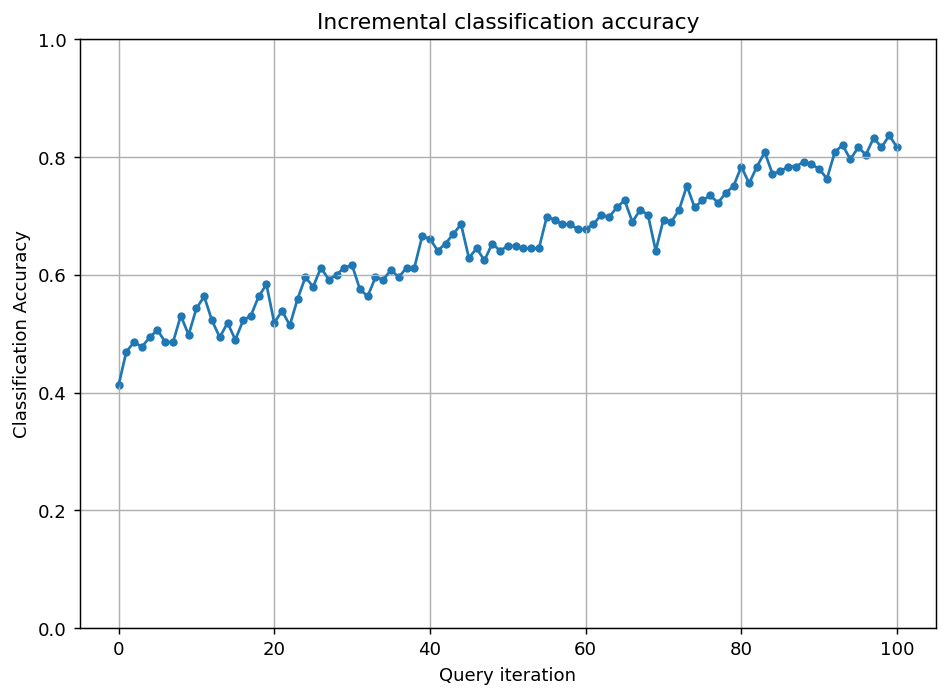

In [17]:
# plot our performance over time
plot_performance_single_model(history_rand_rf)

# 1.2. Uncertainty Sampling (15 pts. total)
**Create an ActiveLearner with <a href="https://modal-python.readthedocs.io/en/latest/content/query_strategies/uncertainty_sampling.html">Uncertainty sampling</a> as the sampling strategy for each of the estimator below.** 

**Report the final accuracy and plot the classification accuracy with respect to number of labels queried for both the uncertainty and random sampling for each estimator.**



## 1.2. Logistic Regression (7.5 pts.)

In [18]:
#?? which uncertainty quantification to use (least confident, smallest margin, entropy)
'''
Upon comparison of the three different uncertainty sampling methods,
uncertainty_sampling appears to produce a model with the best final accuracy
for Logistic Regression.
'''


# copy data for use with this section
X_pool_uncert_lr = copy.deepcopy(X_pool)
y_pool_uncert_lr = copy.deepcopy(y_pool)


# define learner, including training data as starting point
learner = ActiveLearner(
    estimator=LogisticRegression(),
    query_strategy=uncertainty_sampling,
    X_training=X_training, 
    y_training=y_training
)


# run active learner and obtain score history
history_uncert_lr = run_active_learner(learner,X_pool_uncert_lr, y_pool_uncert_lr, X_test, y_test, queries)

In [19]:
# final accuracy
print('Accuracy of Logistic Regression with uncertainty sampling: \t{:.3f}'.format(history_uncert_lr[-1]))

Accuracy of Logistic Regression with uncertainty sampling: 	0.910


## 1.2. Plot classification accuracy with respect to number of labels queried

In [20]:
def plot_performance_two_models(score_history_1, label_1, score_history_2, label_2):
    '''
    Generates a scatterplot of total queries vs score for two given models.
    
    Args:
        score_history_1: List of scores representing the 
        score of the first ActiveLearner model after each query.
        
        label_1: String to identify the first model
        
        score_history_2: List of scores representing the 
        score of the second ActiveLearner model after each query.
        
        label_2: String to identify the second model
    '''
    
    fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

    ax.plot(score_history_1)
    ax.scatter(range(len(score_history_1)), score_history_1, s=13, label = label_1)

    ax.plot(score_history_2)
    ax.scatter(range(len(score_history_2)), score_history_2, s=13, label = label_2)

    ax.set_ylim(bottom=0, top=1)
    ax.grid(True)

    ax.set_title('Incremental classification accuracy')
    ax.set_xlabel('Query iteration')
    ax.set_ylabel('Classification Accuracy')

    ax.legend()

    plt.show()

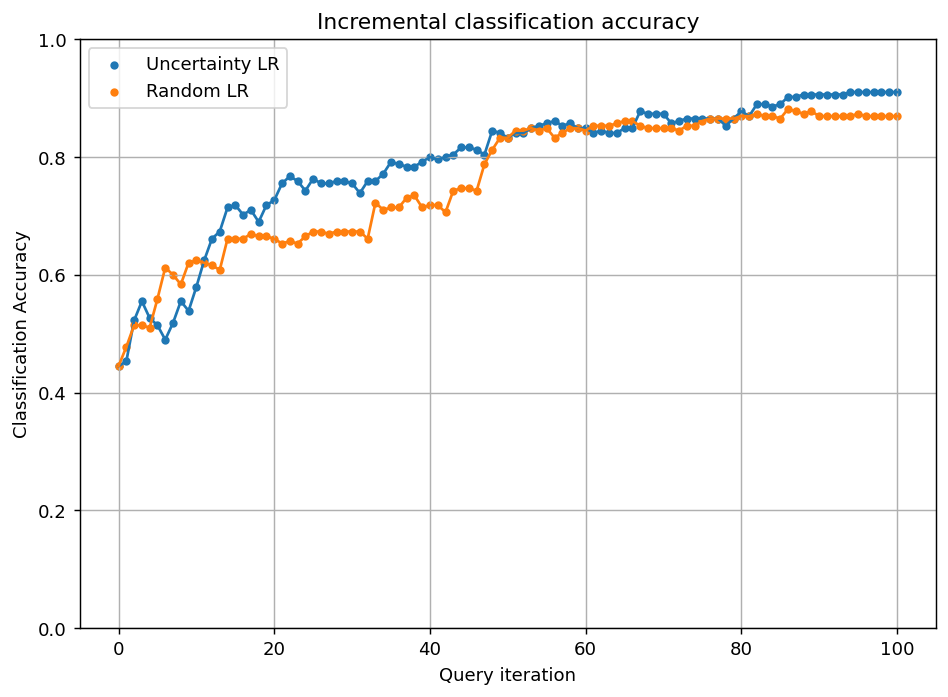

In [21]:
# plot our performance over time
plot_performance_two_models(history_uncert_lr, 'Uncertainty LR', history_rand_lr, 'Random LR')

## 1.2. Random Forest (7.5 pts.)

In [22]:
'''
Upon comparison of the three different uncertainty sampling methods,
margin_sampling appears to produce a model with the best final accuracy
for Random Forest, although uncertainty_sampling produces similar results.
'''

# copy data for use with this section
X_pool_uncert_rf = copy.deepcopy(X_pool)
y_pool_uncert_rf = copy.deepcopy(y_pool)


# define learner, including training data as starting point
learner = ActiveLearner(
    estimator=RandomForestClassifier(n_estimators=20,max_depth=6,random_state=seed),
    query_strategy=uncertainty_sampling,
    X_training=X_training, 
    y_training=y_training
)


# run active learner and obtain score history
history_uncert_rf = run_active_learner(learner,X_pool_uncert_rf, y_pool_uncert_rf, X_test, y_test, queries)

In [23]:
# final accuracy
print('Accuracy of Random Forest Classifier with uncertainty sampling: \t{:.3f}'.format(history_uncert_rf[-1]))

Accuracy of Random Forest Classifier with uncertainty sampling: 	0.845


## 1.2. Plot Classification Accuracy with respect to number of labels queried

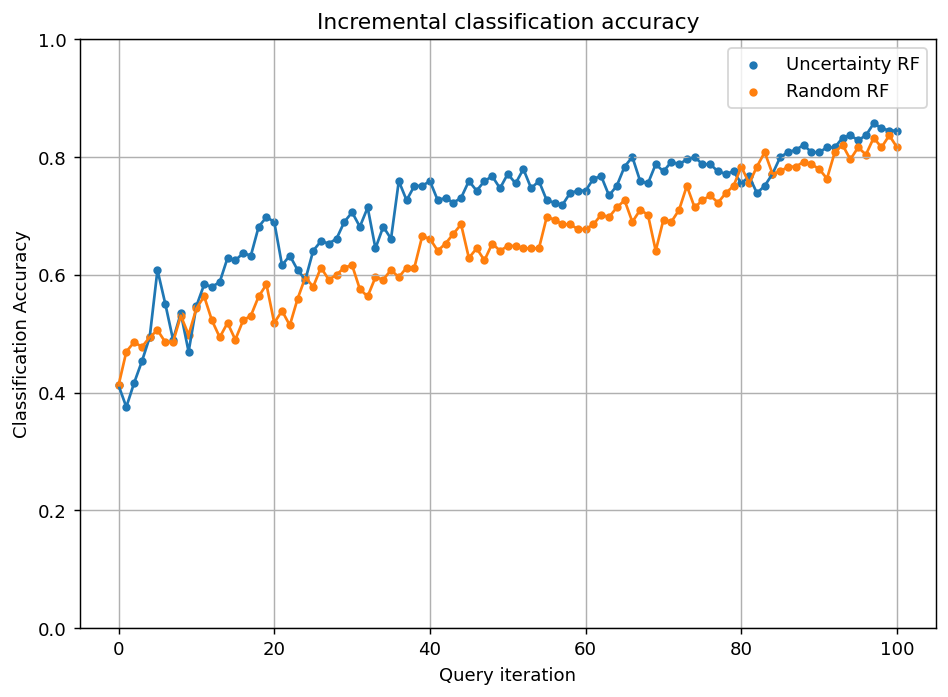

In [24]:
# plot our performance over time
plot_performance_two_models(history_uncert_rf, 'Uncertainty RF', history_rand_rf, 'Random RF')

# 1.3. Density based sampling  (15 pts. total)
**Create an ActiveLearner with <a href="https://modal-python.readthedocs.io/en/latest/content/query_strategies/information_density.html">information density</a> for each of the estimator below.**

- **Use Euclidean metric for similarity and uncertainty for utility function.** 
- **Set $\beta$ = 1.**
- **Report the final accuracy and plot the classification accuracy with respect to number of labels queried for both the uncertainty and random sampling for each estimator.**

## 1.3. Function definitions

Equation to selecting a sample using Information Density:
$$
x^*_{ID} = \underset{x \in U}{argmax}\left(\phi_A(x)\left(\frac{1}{|U|}\sum_{x' \in U}sim(x,x')\right)^\beta\right)
$$

where $\phi()$ is the utility function and $sim()$ is the similiarity function.

### Reason for chosen design
`modAL` doesn't have a single function for information density. It has `classifier_uncertainty()` and `information_density()` but does not combine them for the above calculation.


The library does not have a utility to multiply the two together while also using a desired weighting. (`modAL` has `make_linear_combination()` which does allow weighting, but we want to multiply, not add. The library has `make_product()` but this does not allow weighting.)

In [25]:
#?? how to verify correctness of method?
def density_query_strategy(classifier, X, beta=1, debug=False):
    '''
    Returns a sample chosen using information density as the
    query strategy.
    
    Args:
        classifier: Argument provided by the ActiverLearner.
                
        X: pool of feature data from which to sample.
        
        Beta: the value of the exponent to be used in 
        the Information Density equation. Default value is 1.
        
        debug: Boolean value which toggles output to be 
        used for debugging purposes. Default value is False.
        
    Returns:
        Index of sample and sample features as a tuple 
        (int, numpy array).
        
    Notes:
    (1) Upon comparison of the three different uncertainty utility methods,
        classifier_uncertainty produces a model with the highest accuracy.
    '''
    
    # calculate the utility of each instance in the pool
    utility = classifier_uncertainty(classifier, X)

    # calculate information density of each instance in the pool
    similarity = information_density(X, 'euclidean')

    # multiply each cell in the pair of vectors together
    result = np.multiply(utility, np.power(similarity, beta))

    # get index of instance with max information density
    query_idx = np.argmax(result, axis=0)  
    
    if debug:
        print('utility')
        print(utility)
        print()
        print('similarity')
        print(similarity)
        print()
        print('result')
        print(result)
        print()
        print(result[query_idx])

    return query_idx, X[query_idx]


## 1.3. Logistic regression (7.5 pts.)

In [26]:
# copy data for use with this section
X_pool_dens_lr = copy.deepcopy(X_pool)
y_pool_dens_lr = copy.deepcopy(y_pool)


# define learner, including training data as starting point
learner = ActiveLearner(
    estimator=LogisticRegression(),
    query_strategy=density_query_strategy,
    X_training=X_training, 
    y_training=y_training
)


# run active learner and obtain score history
history_dens_lr = run_active_learner(learner, X_pool_dens_lr, y_pool_dens_lr, X_test, y_test, queries)


In [27]:
# final accuracy
print('Accuracy of Logistic Regression with density-based sampling: \t{:.3f}'.format(history_dens_lr[-1]))

Accuracy of Logistic Regression with density-based sampling: 	0.906


## 1.3. Plot Classification Accuracy with respect to number of labels queried

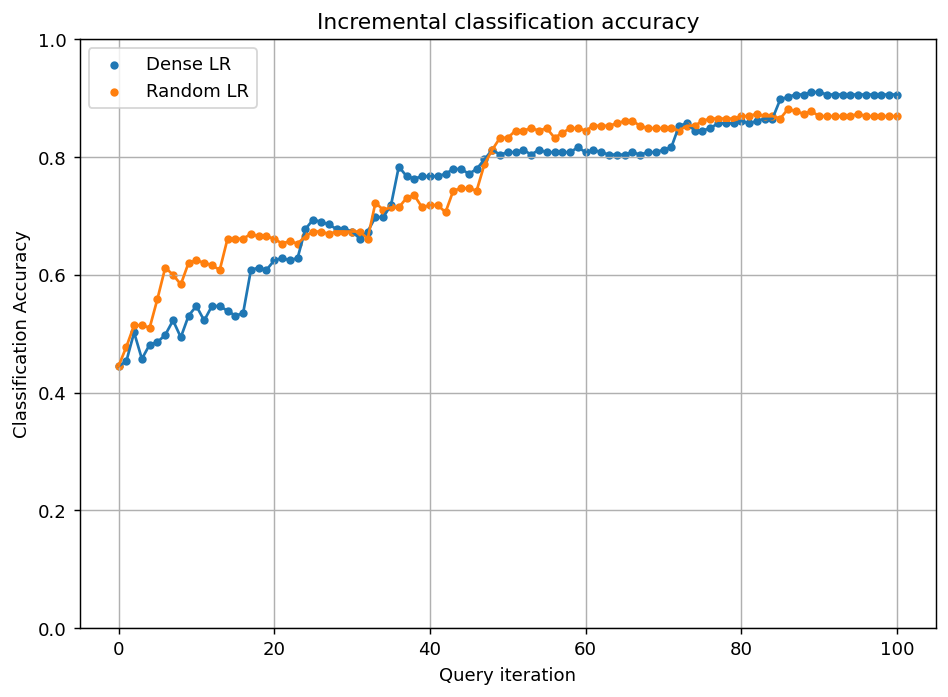

In [28]:
# plot our performance over time
plot_performance_two_models(history_dens_lr, 'Dense LR', history_rand_lr, 'Random LR')

## 1.3. Random Forest (7.5 pts.)

In [29]:
# copy data for use with this section
X_pool_dens_rf = copy.deepcopy(X_pool)
y_pool_dens_rf = copy.deepcopy(y_pool)


# define learner, including training data as starting point
learner = ActiveLearner(
    estimator=RandomForestClassifier(n_estimators=20,max_depth=6,random_state=seed),
    query_strategy=density_query_strategy,
    X_training=X_training, 
    y_training=y_training
)


# run active learner and obtain score history
history_dens_rf = run_active_learner(learner,X_pool_dens_rf, y_pool_dens_rf, X_test, y_test, queries)

In [30]:
# final accuracy
print('Accuracy of Random Forest Classifier with density-based sampling: \t{:.3f}'.format(history_dens_rf[-1]))

Accuracy of Random Forest Classifier with density-based sampling: 	0.812


## 1.3. Plot Classification Accuracy with respect to number of labels queried

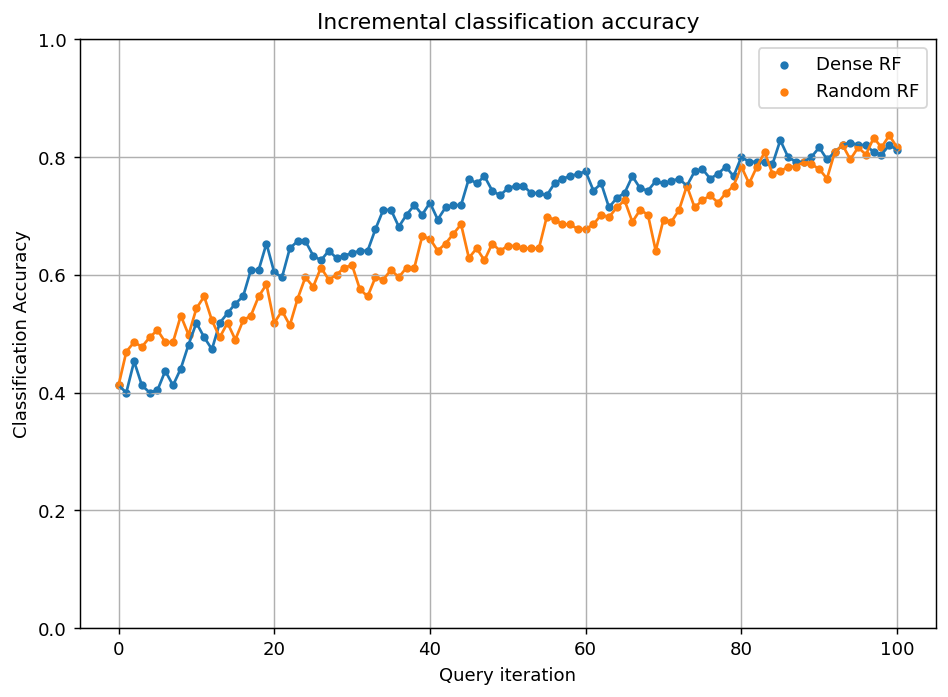

In [31]:
# plot our performance over time
plot_performance_two_models(history_dens_rf, 'Dense RF', history_rand_rf, 'Random RF')

# 1.4. Query-By-Committee with max disagreement sampling   (10 pts. total)

**Finally, we will now use modAL to implement query by committee. We will form a committee with <a href="https://modal-python.readthedocs.io/en/latest/content/query_strategies/Disagreement-sampling.html">max disagreement</a> sampling. Within modAL, forming a committee is as easy as creating a list of ActiveLearners, and passing this along with the query method to Committee(). The Committee object can then be used exactly as the ActiveLearner objects we used in the previous parts (eg. Use Committee.query(X,y) or Committee.teach(X,y), etc.).** 

- **Construct the committee described above, with logistic regression classifier as the first member and random forest as the second.**
- **As in the previous section, perform 100 queries to the oracle, and plot number of queries against prediction accuracy across the test sets and compare with both the random forest and logistic regression classifier with random sampling strategy.**

In [32]:
# copy data for use with this section
X_pool_comm = copy.deepcopy(X_pool)
y_pool_comm = copy.deepcopy(y_pool)


# define the ActiveLearners that are part of the committee
learner_1 = ActiveLearner(
    estimator=LogisticRegression(),
    X_training=X_training, 
    y_training=y_training
)

learner_2 = ActiveLearner(
    estimator=RandomForestClassifier(n_estimators=20,max_depth=6,random_state=seed),
    X_training=X_training, 
    y_training=y_training
)


# define Committee
committee = Committee(learner_list = [learner_1, learner_2],
                     query_strategy = max_disagreement_sampling)


# run active learner and obtain score history
history_comm = run_active_learner(committee,X_pool_comm, y_pool_comm, X_test, y_test, queries)


In [33]:
# final accuracy
print('Accuracy of Committee with max disagreement sampling: \t{:.3f}'.format(history_comm[-1]))

Accuracy of Committee with max disagreement sampling: 	0.878


## 1.4. Plot Classification Accuracy with respect to number of labels queried

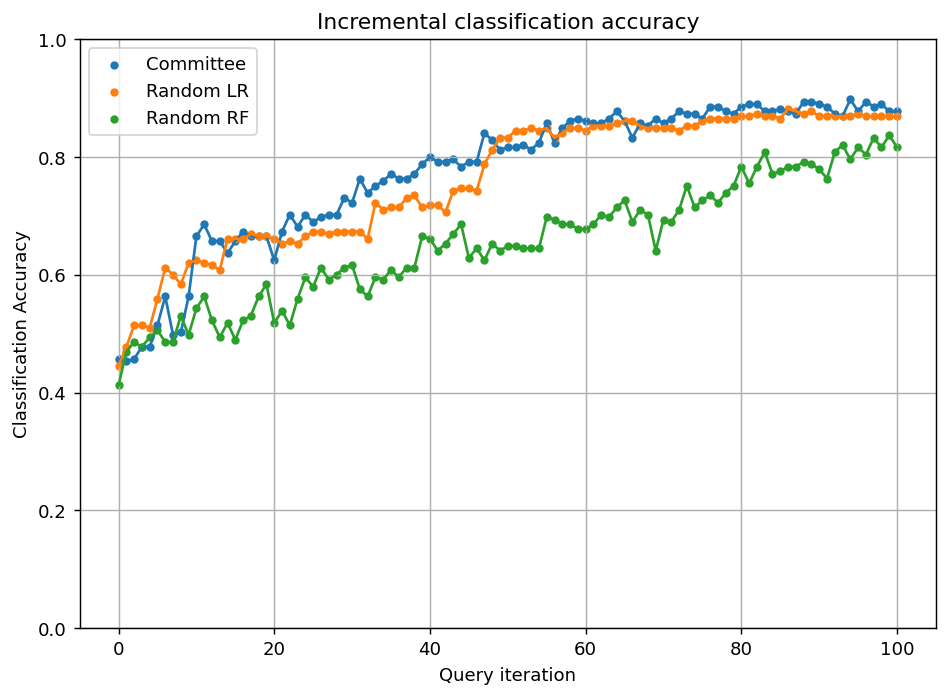

In [34]:
# plot our performance over time
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)


ax.plot(history_comm)
ax.scatter(range(len(history_comm)), history_comm, s=13, label = 'Committee')


ax.plot(history_rand_lr)
ax.scatter(range(len(history_rand_lr)), history_rand_lr, s=13, label = 'Random LR')

ax.plot(history_rand_rf)
ax.scatter(range(len(history_rand_rf)), history_rand_rf, s=13, label = 'Random RF')

ax.set_ylim(bottom=0, top=1)
ax.grid(True)


ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')
ax.legend()
plt.show()

# 1.5. Plot Classification Accuracy across all sampling methods
The four methods are as follows:
1. Random Sampling

2. Uncertainty Sampling

3. Density based-sampling

4. Committee

## 1.5. Logistic Regression

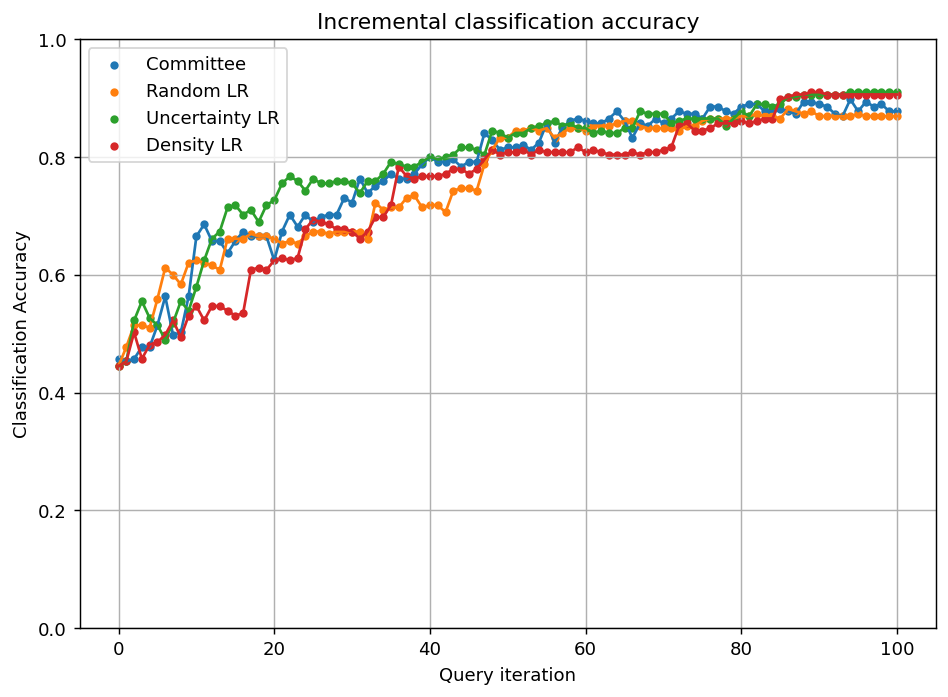

In [35]:
# plot our performance over time
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)


ax.plot(history_comm)
ax.scatter(range(len(history_comm)), history_comm, s=13, label = 'Committee')

ax.plot(history_rand_lr)
ax.scatter(range(len(history_rand_lr)), history_rand_lr, s=13, label = 'Random LR')

ax.plot(history_uncert_lr)
ax.scatter(range(len(history_uncert_lr)), history_uncert_lr, s=13, label = 'Uncertainty LR')

ax.plot(history_dens_lr)
ax.scatter(range(len(history_dens_lr)), history_dens_lr, s=13, label = 'Density LR')

ax.set_ylim(bottom=0, top=1)
ax.grid(True)


ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')
ax.legend()
plt.show()

## 1.5. Random Forest

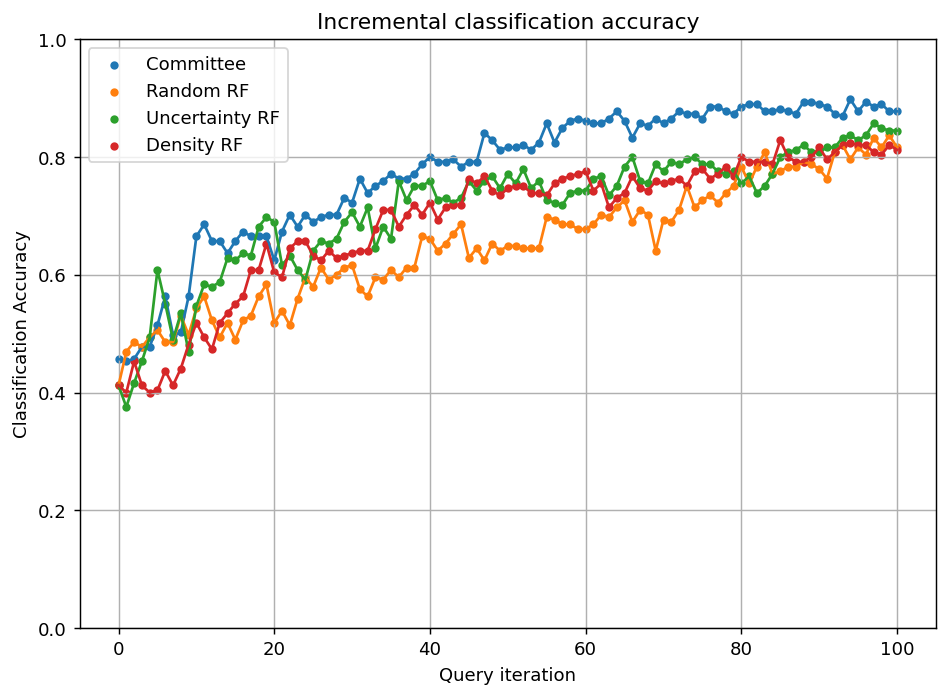

In [36]:
# plot our performance over time
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)


ax.plot(history_comm)
ax.scatter(range(len(history_comm)), history_comm, s=13, label = 'Committee')

ax.plot(history_rand_rf)
ax.scatter(range(len(history_rand_rf)), history_rand_rf, s=13, label = 'Random RF')

ax.plot(history_uncert_rf)
ax.scatter(range(len(history_uncert_rf)), history_uncert_rf, s=13, label = 'Uncertainty RF')

ax.plot(history_dens_rf)
ax.scatter(range(len(history_dens_rf)), history_dens_rf, s=13, label = 'Density RF')

ax.set_ylim(bottom=0, top=1)
ax.grid(True)


ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')
ax.legend()
plt.show()

## 1.5. Both

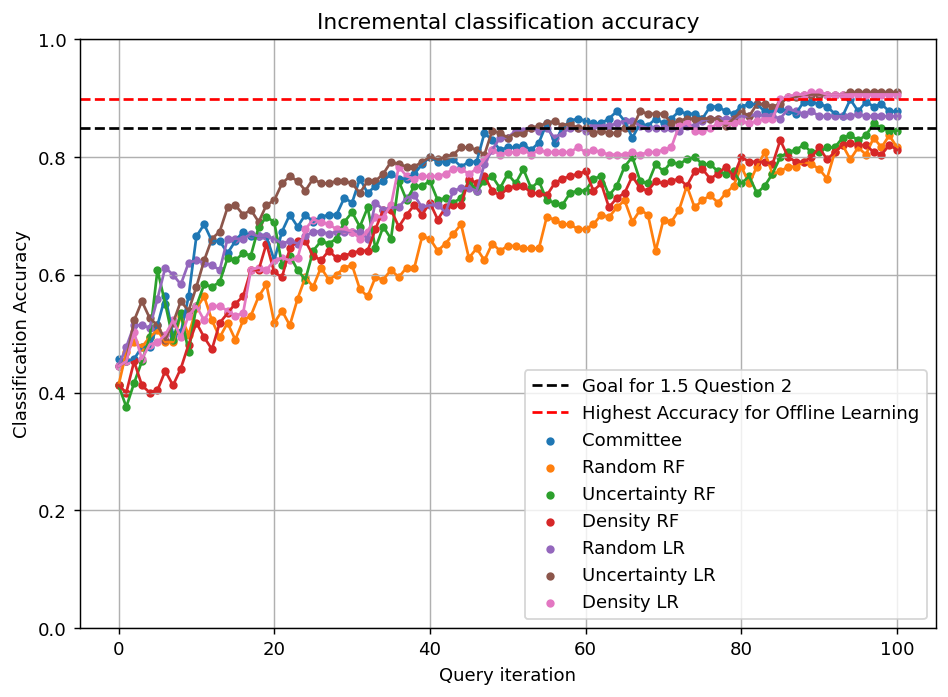

In [39]:
# plot our performance over time
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)


ax.plot(history_comm)
ax.scatter(range(len(history_comm)), history_comm, s=13, label = 'Committee')

ax.plot(history_rand_rf)
ax.scatter(range(len(history_rand_rf)), history_rand_rf, s=13, label = 'Random RF')

ax.plot(history_uncert_rf)
ax.scatter(range(len(history_uncert_rf)), history_uncert_rf, s=13, label = 'Uncertainty RF')

ax.plot(history_dens_rf)
ax.scatter(range(len(history_dens_rf)), history_dens_rf, s=13, label = 'Density RF')

ax.plot(history_rand_lr)
ax.scatter(range(len(history_rand_lr)), history_rand_lr, s=13, label = 'Random LR')

ax.plot(history_uncert_lr)
ax.scatter(range(len(history_uncert_lr)), history_uncert_lr, s=13, label = 'Uncertainty LR')

ax.plot(history_dens_lr)
ax.scatter(range(len(history_dens_lr)), history_dens_lr, s=13, label = 'Density LR')

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

# add horizontal lines for reference
ax.axhline(y=0.85,color='black',linestyle='dashed', label='Goal for 1.5 Question 2') 
ax.axhline(y=0.898,color='red',linestyle='dashed', label='Highest Accuracy for Offline Learning') 

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')
ax.legend()
plt.show()

## 1.5. Question
**As you’ve seen in this example, the incremental improvement of accuracy by querying new labels vary across different sampling strategies and estimator.**

**1. Given you only have enough labeling budget of 20 samples, which query strategy/estimator would you use?** 

*Given a budget of 20 samples, I would use uncertainty sampling with Logistic Regression. It had the highest accuracy among all strategies at 20 samples.*


**2. If the goal was to achieve an 85% accuracy, which strategy/estimator would you use?**

*Given a goal of 85% accuracy, I would use uncertainty sampling with Logistic Regression. It was the fastest model to arrive at 85% accuracy, which means I would need fewer samples (i.e. less cost) to achieve the goal. Compared to the randomized logistic regression model, Logistic Regression with uncertainty sampling is more likely to achieve 85% faster due to its use of a heuristic.*